In [1]:
#Imports
import os
import cv2
import pandas as pd
from time import time
import numpy as np
import shutil
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model,layers,Input
from shutil import copyfile
from tqdm import tqdm
import optuna
from optuna.samplers import RandomSampler
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
import tensorflow_datasets as tfds

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 6]

# Set the seeds for reproducibility
from numpy.random import seed
from tensorflow.random import set_seed
seed_value = 888
seed(seed_value)
set_seed(seed_value)

In [2]:
#Fuction for data preprocessing
def preprocess(image, label):
    # Resize (for save recources) and normalize images (for proper training)
    image = tf.image.resize(image, [64, 64])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Dataset loading
train_ds_all, test_ds_all = tfds.load('malaria', split=['train[:80%]', 'train[80%:]'], shuffle_files=True, as_supervised=True)

# Apply the preprocessing function
train_ds = train_ds_all.map(preprocess).batch(128).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds_all.map(preprocess).batch(128).prefetch(tf.data.AUTOTUNE)

In [3]:
# Some function for descriptive statistic
def compute_descriptive_statistics(dataset):
    # Initialization of variables
    num_samples = 0
    num_classes = 2
    class_counts = np.zeros(num_classes, dtype=int)
    
    for image, label in dataset:
        num_samples += 1  # Counting the total number of observations
        class_counts[label.numpy()] += 1  # Counting the number of observations for each class
    
    # Output of statistics
    print(f"Total number of samples: {num_samples}")
    for i, count in enumerate(class_counts):
        print(f"Class {i} count: {count}")
    print(f"Class distribution: {class_counts / num_samples * 100}%")

In [4]:
# Info of train sample
compute_descriptive_statistics(train_ds_all)

Total number of samples: 22046
Class 0 count: 10999
Class 1 count: 11047
Class distribution: [49.89113671 50.10886329]%


In [5]:
# Info of test sample
compute_descriptive_statistics(test_ds_all)

Total number of samples: 5512
Class 0 count: 2780
Class 1 count: 2732
Class distribution: [50.43541364 49.56458636]%


In [6]:
#Lets try run base model. we use sigmoid because we are working with two classes 
model_base = tf.keras.Sequential([
  tf.keras.Input(shape=(64, 64, 3)),
  layers.Conv2D(32, kernel_size=(3, 3), padding='same'),
  layers.Activation('relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Flatten(),
  layers.Dense(1, activation="sigmoid"),
])

model_base.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │          32,769 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,665 (131.50 KB)

 Trainable params: 33,665 (131.50 KB)

 Non-trainable params: 0 (0.00 B)

As we can see, this is a very simple model with a small number of parameters, but it can potentially show overfitting. let's check it out.

In [10]:
#Function for plot training result
def plot_history(history):
    h = history.history
    epochs = range(len(h['loss']))

    plt.subplot(121), plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
    plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
    plt.legend(['Train', 'Validation'])
    plt.subplot(122), plt.plot(epochs, h['binary_accuracy'], '.-',
                               epochs, h['val_binary_accuracy'], '.-')
    plt.grid(True), plt.xlabel('epochs'), plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'])
        
    print('Train Acc     ', h['binary_accuracy'][-1])
    print('Validation Acc', h['val_binary_accuracy'][-1])

In [8]:
epochs = 5
batch_size = 128

model_base.compile(loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"])
history_base = model_base.fit(train_ds, batch_size=batch_size, epochs=epochs, validation_data=test_ds)

Epoch 1/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/step - binary_accuracy: 0.6073 - loss: 0.6703 - val_binary_accuracy: 0.6863 - val_loss: 0.5904
Epoch 2/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step - binary_accuracy: 0.7056 - loss: 0.5791 - val_binary_accuracy: 0.7202 - val_loss: 0.5636
Epoch 3/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - binary_accuracy: 0.7364 - loss: 0.5458 - val_binary_accuracy: 0.7357 - val_loss: 0.5426
Epoch 4/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - binary_accuracy: 0.7683 - loss: 0.5109 - val_binary_accuracy: 0.7705 - val_loss: 0.5130
Epoch 5/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - binary_accuracy: 0.7971 - loss: 0.4752 - val_binary_accuracy: 0.7897 - val_loss: 0.4896


Train Acc      0.7965163588523865
Validation Acc 0.789731502532959


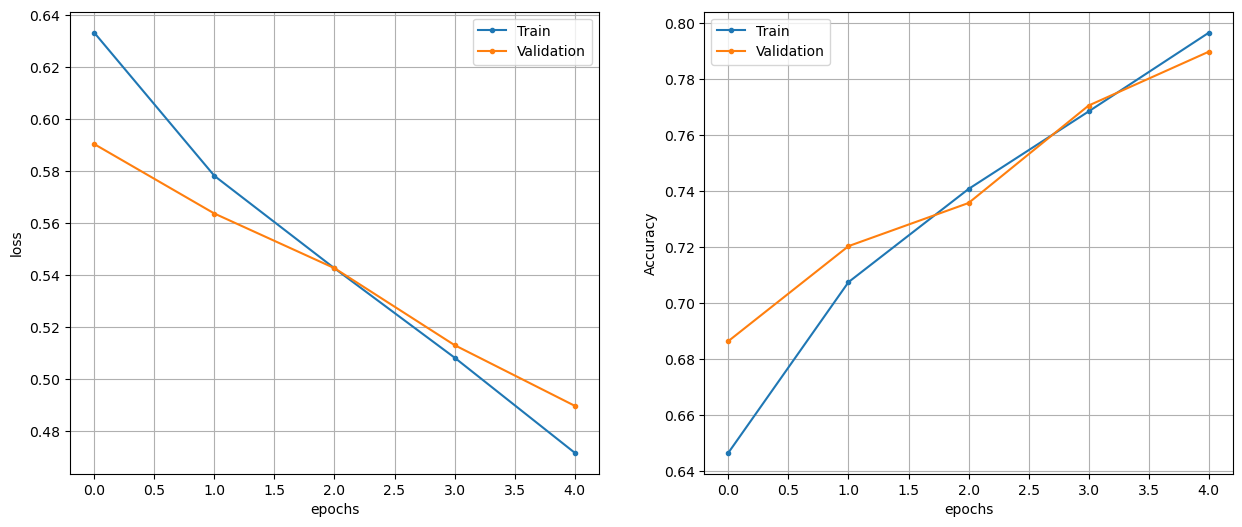

In [11]:
plot_history(history_base)

Let's try to complicate the model for better accuracy

In [15]:
#let's create 2 layers for data augmentation
data_augmentation_flip = tf.keras.Sequential([
  layers.RandomFlip()  
])
data_augmentation_contrast = tf.keras.Sequential([
  layers.RandomContrast(0.2)  
])

In [16]:
#Attempt to manually tune model parameters to improve accuracy
model_m = tf.keras.Sequential([
  tf.keras.Input(shape=(64, 64, 3)),
  data_augmentation_contrast,
  data_augmentation_flip,
  layers.Conv2D(16, kernel_size=(3, 3), padding='same'),
  layers.Activation('relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(32, kernel_size=(3, 3), padding='same'),
  layers.BatchNormalization(),
  layers.Activation('relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Dropout(0.1),
  layers.Conv2D(64, kernel_size=(3, 3), padding='same'),
  layers.BatchNormalization(),
  layers.Activation('relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Flatten(),
  layers.Dropout(0.4),  
  layers.Dense(1, activation="sigmoid"),
])

model_m.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)            │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_3 (Sequential)            │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │           4,097 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,065 (109.63 KB)

 Trainable params: 27,873 (108.88 KB)

 Non-trainable params: 192 (768.00 B)

In [18]:
epochs = 5
batch_size = 64

model_m.compile(loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"])
history_m = model_m.fit(train_ds, batch_size=batch_size, epochs=epochs, validation_data=test_ds)

Epoch 1/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 22s 111ms/step - binary_accuracy: 0.6288 - loss: 0.7920 - val_binary_accuracy: 0.4956 - val_loss: 0.9424
Epoch 2/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 110ms/step - binary_accuracy: 0.8536 - loss: 0.3419 - val_binary_accuracy: 0.4966 - val_loss: 1.5934
Epoch 3/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 20s 112ms/step - binary_accuracy: 0.9307 - loss: 0.1971 - val_binary_accuracy: 0.7712 - val_loss: 0.5220
Epoch 4/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 111ms/step - binary_accuracy: 0.9413 - loss: 0.1704 - val_binary_accuracy: 0.9532 - val_loss: 0.1954
Epoch 5/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 110ms/step - binary_accuracy: 0.9471 - loss: 0.1542 - val_binary_accuracy: 0.9454 - val_loss: 0.1621


Train Acc      0.9452508687973022
Validation Acc 0.9453918933868408


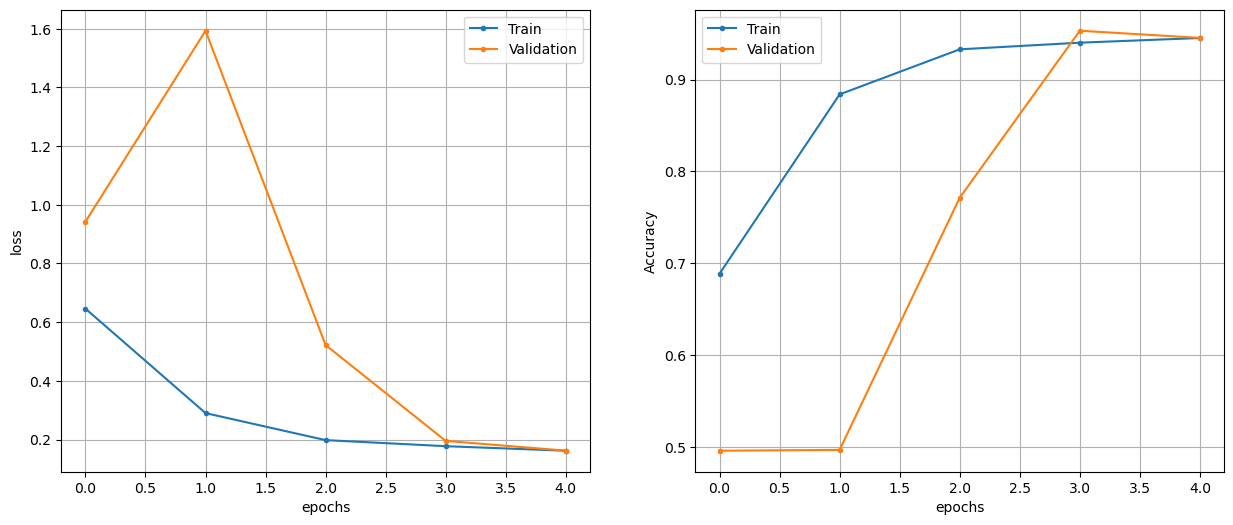

In [19]:
#It is a better result. Let's see it:
plot_history(history_m)

In [20]:
# let's try automatic hyperparameter tuning
INPUT_SHAPE = (64, 64, 3)
#BATCHSIZE=128
EPOCHS=5

In [21]:
def objective(trial):
    """Objective function that controls the quality of the different runs.
    
    Args:
        trial (optuna.trial.Trial) Wrapper that controls the launching and the
            hyper-parameters of the different runs.
            
    Returns:
        (float) The quality metric of the current run.
        
    """    
    BATCHSIZE = trial.suggest_categorical("batch_size", [32, 64, 128])
    # Build model
    model = Sequential()
    model.add(tf.keras.Input(shape=INPUT_SHAPE)),
    model.add(data_augmentation_flip),
    model.add(
        Conv2D(
            filters=trial.suggest_categorical("filters", [32, 64, 128]),
            kernel_size=trial.suggest_categorical("kernel_size", [3, 5, 7]),
            activation="relu",
            input_shape=INPUT_SHAPE,
        )
    )
    model.add(MaxPooling2D(pool_size=(2, 2))),
    model.add(
        Conv2D(
            filters=trial.suggest_categorical("filters", [32, 64, 128]),
            kernel_size=trial.suggest_categorical("kernel_size", [3, 5, 7]),
            activation="relu")
    ),
    model.add(MaxPooling2D(pool_size=(2, 2))),
    model.add(Dropout(rate=trial.suggest_categorical("rate", [0, 0.1, 0.2, 0.4]))),  
    model.add(
        Conv2D(
            filters=trial.suggest_categorical("filters", [32, 64, 128]),
            kernel_size=trial.suggest_categorical("kernel_size", [3, 5, 7]),
            activation="relu")
    ),
    model.add(MaxPooling2D(pool_size=(2, 2))),
    model.add(Flatten()),
    model.add(Dropout(rate=trial.suggest_categorical("rate", [0, 0.1, 0.2, 0.4]))),  
    model.add(Dense(1, activation="sigmoid"))

    # Compile model with sampled learning rate.
    model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=["binary_accuracy"],
    )

    # Run training
    model.fit(train_ds, batch_size=batch_size, epochs=epochs, shuffle=True)

    # Evaluate model quality (performance on validation set)
    return model.evaluate(test_ds, verbose=0)[1]

In [28]:
# Create Optuna study with MedianPruner
study = optuna.create_study(direction="maximize",sampler=RandomSampler(),pruner=optuna.pruners.MedianPruner(
        n_startup_trials=2, n_warmup_steps=10, interval_steps=5))

# Launch hyper-parameter search
study.optimize(objective, n_trials=5)

print('Number of finished trials:', len(study.trials))

# Show detailed info about finished trials
study.trials_dataframe()

[I 2024-04-07 23:58:00,760] A new study created in memory with name: no-name-e9e600f8-d2b0-4357-87de-0c103212739c


Epoch 1/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 97ms/step - binary_accuracy: 0.5988 - loss: 0.6558
Epoch 2/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 105ms/step - binary_accuracy: 0.7621 - loss: 0.5053
Epoch 3/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 99ms/step - binary_accuracy: 0.9254 - loss: 0.2107
Epoch 4/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 97ms/step - binary_accuracy: 0.9436 - loss: 0.1670
Epoch 5/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 98ms/step - binary_accuracy: 0.9507 - loss: 0.1554


[I 2024-04-07 23:59:31,376] Trial 0 finished with value: 0.9493831396102905 and parameters: {'batch_size': 32, 'filters': 32, 'kernel_size': 3, 'rate': 0.1}. Best is trial 0 with value: 0.9493831396102905.


Epoch 1/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 25s 130ms/step - binary_accuracy: 0.5654 - loss: 0.6749
Epoch 2/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 130ms/step - binary_accuracy: 0.6883 - loss: 0.5954
Epoch 3/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - binary_accuracy: 0.7870 - loss: 0.4530
Epoch 4/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - binary_accuracy: 0.8914 - loss: 0.2746
Epoch 5/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - binary_accuracy: 0.9268 - loss: 0.2088


[I 2024-04-08 00:01:30,027] Trial 1 finished with value: 0.9310594797134399 and parameters: {'batch_size': 128, 'filters': 32, 'kernel_size': 5, 'rate': 0}. Best is trial 0 with value: 0.9493831396102905.


Epoch 1/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 93s 523ms/step - binary_accuracy: 0.5364 - loss: 0.6915
Epoch 2/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 92s 529ms/step - binary_accuracy: 0.6698 - loss: 0.6144
Epoch 3/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 92s 530ms/step - binary_accuracy: 0.7491 - loss: 0.5085
Epoch 4/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 92s 531ms/step - binary_accuracy: 0.8518 - loss: 0.3522
Epoch 5/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 93s 537ms/step - binary_accuracy: 0.8964 - loss: 0.2750


[I 2024-04-08 00:09:18,820] Trial 2 finished with value: 0.9098330736160278 and parameters: {'batch_size': 32, 'filters': 64, 'kernel_size': 7, 'rate': 0.1}. Best is trial 0 with value: 0.9493831396102905.


Epoch 1/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 327s 2s/step - binary_accuracy: 0.5787 - loss: 0.6895
Epoch 2/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 328s 2s/step - binary_accuracy: 0.7053 - loss: 0.5758
Epoch 3/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 361s 2s/step - binary_accuracy: 0.8357 - loss: 0.3798
Epoch 4/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 352s 2s/step - binary_accuracy: 0.8829 - loss: 0.2973
Epoch 5/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 344s 2s/step - binary_accuracy: 0.9097 - loss: 0.2517


[I 2024-04-08 00:38:17,736] Trial 3 finished with value: 0.9256168603897095 and parameters: {'batch_size': 32, 'filters': 128, 'kernel_size': 7, 'rate': 0.4}. Best is trial 0 with value: 0.9493831396102905.


Epoch 1/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 148s 844ms/step - binary_accuracy: 0.6245 - loss: 0.6365
Epoch 2/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 148s 855ms/step - binary_accuracy: 0.9393 - loss: 0.1836
Epoch 3/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 150s 864ms/step - binary_accuracy: 0.9528 - loss: 0.1483
Epoch 4/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 149s 861ms/step - binary_accuracy: 0.9543 - loss: 0.1413
Epoch 5/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 150s 865ms/step - binary_accuracy: 0.9558 - loss: 0.1390


[I 2024-04-08 00:50:53,493] Trial 4 finished with value: 0.9537373185157776 and parameters: {'batch_size': 32, 'filters': 128, 'kernel_size': 3, 'rate': 0}. Best is trial 4 with value: 0.9537373185157776.


Number of finished trials: 5


,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_filters,params_kernel_size,params_rate,state
0,0,0.949383,2024-04-07 23:58:00.767299,2024-04-07 23:59:31.376553,0 days 00:01:30.609254,32,32,3,0.1,COMPLETE
1,1,0.931059,2024-04-07 23:59:31.378002,2024-04-08 00:01:30.026797,0 days 00:01:58.648795,128,32,5,0.0,COMPLETE
2,2,0.909833,2024-04-08 00:01:30.028355,2024-04-08 00:09:18.820117,0 days 00:07:48.791762,32,64,7,0.1,COMPLETE
3,3,0.925617,2024-04-08 00:09:18.821114,2024-04-08 00:38:17.736303,0 days 00:28:58.915189,32,128,7,0.4,COMPLETE
4,4,0.953737,2024-04-08 00:38:17.737300,2024-04-08 00:50:53.493597,0 days 00:12:35.756297,32,128,3,0.0,COMPLETE


(Text(0.5, 0, 'trial'), Text(0, 0.5, 'metric'))

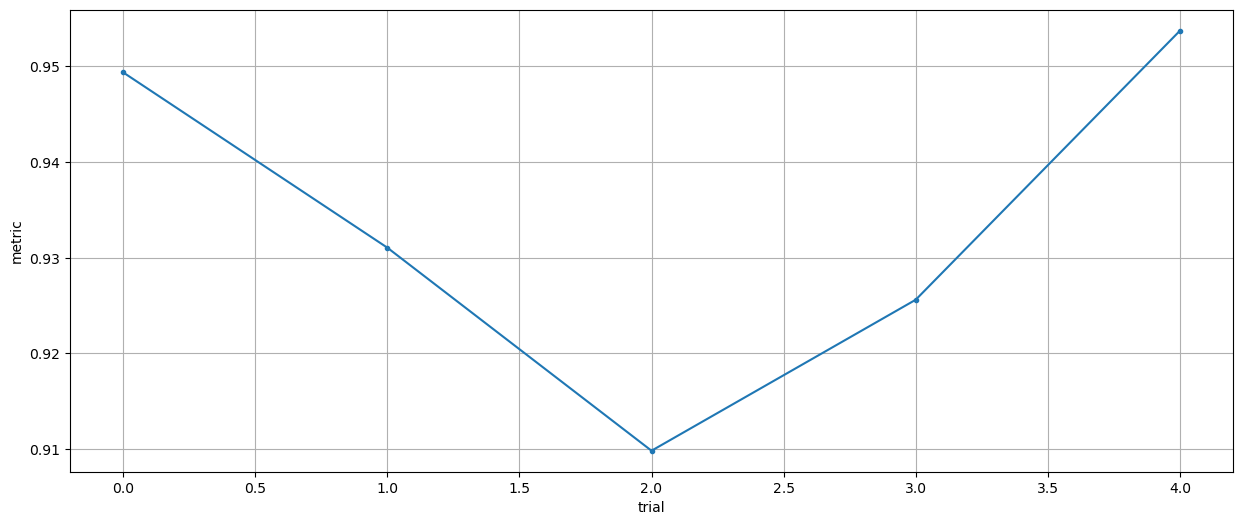

In [29]:
#Show metrics for all trials
metrics = [trial.value for trial in study.trials]
plt.plot(metrics, '.-'), plt.grid(True)
plt.xlabel('trial'), plt.ylabel('metric')

In [30]:
# Show best trial
trial = study.best_trial
print('Best trial:', trial.number, '\n')
print('  Metric:', trial.value)
print('  Params:')
for key, value in trial.params.items():
    print('\t', key.ljust(13), ':', value)

Best trial: 4 

  Metric: 0.9537373185157776
  Params:
	 batch_size    : 32
	 filters       : 128
	 kernel_size   : 3
	 rate          : 0


In [31]:
#let's specify the parameters of the best model
model_best = tf.keras.Sequential([
  tf.keras.Input(shape=(64, 64, 3)),
  data_augmentation_flip,
  layers.Conv2D(128, kernel_size=(3, 3), padding='same'),
  layers.Activation('relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(128, kernel_size=(3, 3), padding='same'),
  layers.BatchNormalization(),
  layers.Activation('relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Dropout(0),
  layers.Conv2D(128, kernel_size=(3, 3), padding='same'),
  layers.BatchNormalization(),
  layers.Activation('relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Flatten(),
  layers.Dropout(0),  
  layers.Dense(1, activation="sigmoid"),
])

model_best.summary()

epochs = 5
batch_size = 32

model_best.compile(loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"])
history_best = model_best.fit(train_ds, batch_size=batch_size, epochs=epochs, validation_data=test_ds)

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)            │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (None, 64, 64, 128)         │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_40 (MaxPooling2D)      │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_41 (MaxPooling2D)      │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_42 (MaxPooling2D)      │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_14 (Flatten)                 │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │           8,193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 307,969 (1.17 MB)

 Trainable params: 307,457 (1.17 MB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - binary_accuracy: 0.6458 - loss: 0.8907 - val_binary_accuracy: 0.5045 - val_loss: 0.7756
Epoch 2/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - binary_accuracy: 0.9203 - loss: 0.2235 - val_binary_accuracy: 0.8476 - val_loss: 0.4633
Epoch 3/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 211s 1s/step - binary_accuracy: 0.9477 - loss: 0.1516 - val_binary_accuracy: 0.8902 - val_loss: 0.2638
Epoch 4/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 215s 1s/step - binary_accuracy: 0.9511 - loss: 0.1405 - val_binary_accuracy: 0.6963 - val_loss: 0.4929
Epoch 5/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 215s 1s/step - binary_accuracy: 0.9530 - loss: 0.1341 - val_binary_accuracy: 0.9459 - val_loss: 0.1647


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


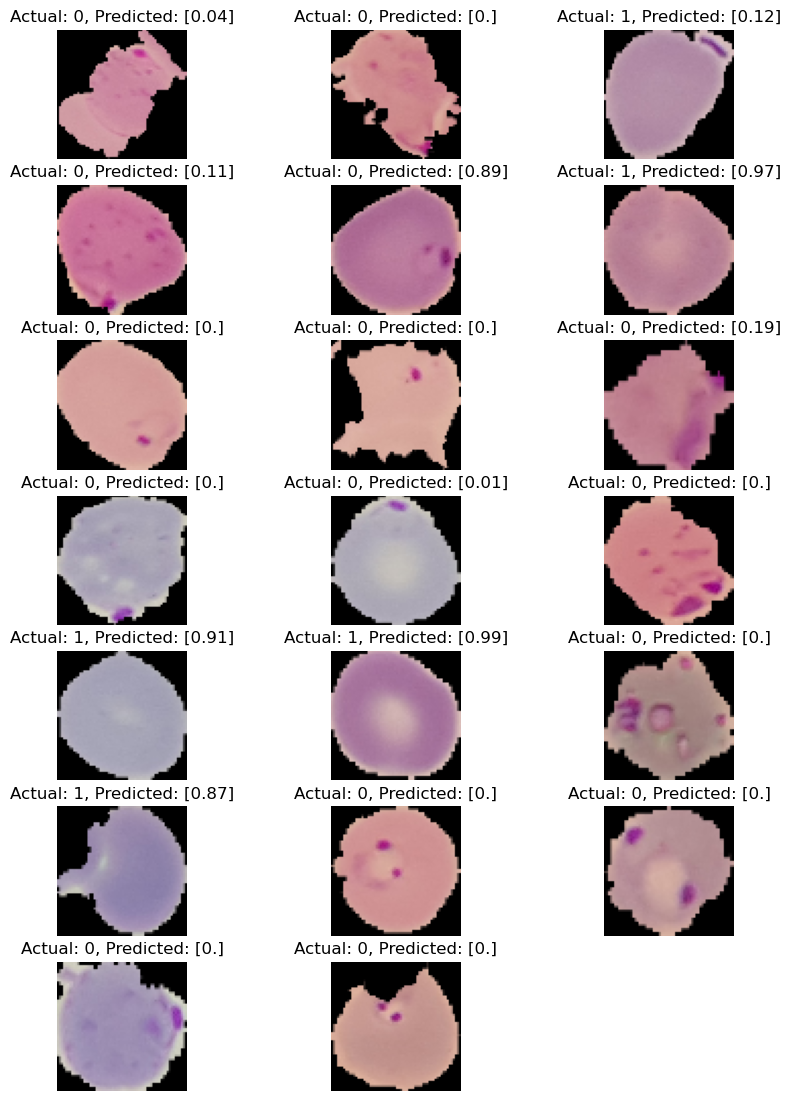

In [34]:
# Choose random images for manual model
def get_random_samples(dataset, num_samples=5):
    images, labels = next(iter(dataset.unbatch().batch(num_samples).prefetch(1)))
    return images.numpy(), labels.numpy()

# Show with predictions
def display_images_with_predictions(images, labels, predictions):
    plt.figure(figsize=(10, num_samples * 2))
    for i in range(images.shape[0]):
        plt.subplot(num_samples, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"Actual: {labels[i]}, Predicted: {np.round(predictions[i], 2)}")
        plt.axis("off")
    plt.show()

# Random images
num_samples = 20
random_images, random_labels = get_random_samples(test_ds, num_samples)

# Predictions
predictions = model_m.predict(random_images)

# Show results
display_images_with_predictions(random_images, random_labels, predictions)

Automatic parameter selection method with similar accuracy as manual, but the model with manual-tuned parameters has a more regular distribution of accuracy across epochs. I am going to investigate the automatic optimization of the parameters at a larger number of epochs to improve the accuracy. It is also planned to investigate the model with the recall metric, which may be more optimal in the context of this task.